# Wstęp

Poruszaliśmy już temat szyfrów symetrycznych blokowych i asymetrycznych, funkcji skrótu, podpisów cyfrowych, paddingowania, masek, krzywych elitpycznych i wiele pomniejszych. W tym laboratorium uzupełnimy wiedzę o pewne algorytmy uzupełniające. Będziemy więc mieli troszkę więcej, ale pomniejszych tematów.

## Szyfr Vernama oraz Blum-Blum-Shub

Szyfr Vernama jest szyfrem symetrycznym (co już zakładam wiesz co znaczy) oraz strumieniowym - czyli wiadomość jest szyfrowana jako całość. Musimy więc mieć klucz tak długi, jak wiadomość, którą chcemy zaszyfrować.

Szyfrowanie szyfrem Vernama:

\begin{equation}
  C = M ⊕ K
\end{equation}

Gdzie $K$ to tajny klucz o długości $M$, $M$ to wiadomość, natomiast $C$ kryptogram.

Deszyfrowanie szyfru Vernama:

\begin{equation}
  M = C ⊕ K
\end{equation}

Oznaczenia jak wyżej.

Czyli jak widzisz, sprawa jest bardzo prosta i opiera się na odwracalności operacji XOR. Pamiętaj, że dla dowolnych różnych słów binarnych A oraz B zachodzi $A = A ⊕ B ⊕ B$, choć rzecz jasna $A \neq A ⊕ B$. To jest właśnie ta odwracalność. Do zastsowania szyfru Vernama jedyne więc czego potrzebujemy, to bezpiecznego, pseudolosowego klucza $K$. Tutaj można by też mówić, że wiadomość nie powinna być zbyt krótka itp. itd. - tym razem dla uproszczenia to pominiemy.

Do wygenerowania pseudoloswej wartości używamy...

...

...

...

Tak jest! Generatora liczb pseudolosowych. Przykładem takiego generatora jest Blum-Blum-Shub. Jego zaletą jest to, że jest uznany za bezpieczny (pod pewnymi warunkami), dlatego może być używany nawet dziś. Jego wadą jest to, że jest wolny. Jest wolny dlatego, że w każdej iteracji algorytmu generuje on losowy **bit**, a więc trzeba iterować tyle razy, ile bitów potrzebujemy.

Blum-Blum-Shub PRNG

1. Znajdź dwie, różne, losowe liczby pierwsze $p$ oraz $q$, ale takie, że: $p \text{ mod } 4 = 3$ oraz $q \text{ mod } 4 = 3$.
2. Oblicz: $n = p * q$.
3. Zainicjalizuj: $K = [empty]$.
4. Znajdź losowe ziarno generatora $s$ (teoretycznie) z przedziału $[0, n - 1]$. Na potrzeby naszego laboratorium niech długość bitowa $s$ będzie równa przynajmniej $\frac{1}{4}$ długości bitowej $n$.
5. Oblicz: $x_1 = s^2 \text{ mod } n$.
6. Rozpocznij pętlę i wykonuj kroki 7 oraz 8 dokładnie tyle razy, ile bitów losowych potrzebujesz.
7. Oblicz $x_t = x_{t - 1}^2 \text{ mod } n$.
8. Dopisz najmniej znaczący bit $x_t$ do klucza $K$.

In [1]:
from random import randint, shuffle
import math
import Crypto.Util.number as cu

nlen = 2048


def number_diff(a, b):
    c = a ^ b
    diff = 0
    while c > 0:
        diff += c % 2
        c //=2
    return diff

def generate_numbers():
    p = cu.getPrime(nlen//2)
    while p % 4 != 3:
        p = cu.getPrime(nlen//2)
    q = cu.getPrime(nlen//2)
    while q % 4 != 3:
        q = cu.getPrime(nlen//2)
    diff = number_diff(p, q)
    if diff < 128:
        return generate_numbers()
    return p, q, p * q

def blum_blum_shub(size):
    p, q, n = generate_numbers()
    K = 0
    s = randint(pow(2, nlen//4), pow(2, nlen) - 1)
    x = pow(s, 2, n)
    for _ in range(size):
        x = pow(x, 2, n)
        K *= 2
        K += x % 2
    return K

def encrypt(M):
    M_bytes = M.encode("utf-8")
    size = len(M_bytes)
    K = blum_blum_shub(size * 8)
    M_int = int.from_bytes(M_bytes)
    C = K ^ M_int
    return C, K

def decrypt(C, K):
    M_int = C ^ K
    size = cu.size(M_int)
    M_bytes = M_int.to_bytes(size // 8 + 1)
    return M_bytes.decode("utf-8")

message = "Ala ma kota."
C, K = encrypt(message)
print(f"{C=}")
decrypted = decrypt(C, K)
print(f"{decrypted=}")

assert decrypted == message
print("Success")

C=6611106962136789392085320330
decrypted='Ala ma kota.'
Success


## GCD oraz Inverse Modulo

Obie te funkcje przejwijały się dość często podczas naszych laboratoriów. Spójrzmy więc, jak je obliczyć.

## GCD

GCD to inaczej największy wspólny dzielnik dwóch liczb. Efektywny algorytm znalezienia tej wartości wymyślił niejaki Euklides jakieś 300 lat p.n.e. Nie będę tego algorytmu rozpisywał w krokach, gdyż łatwiej jest go zaprezentować graficznie. Poniżej przykład dla GCD(22, 59):

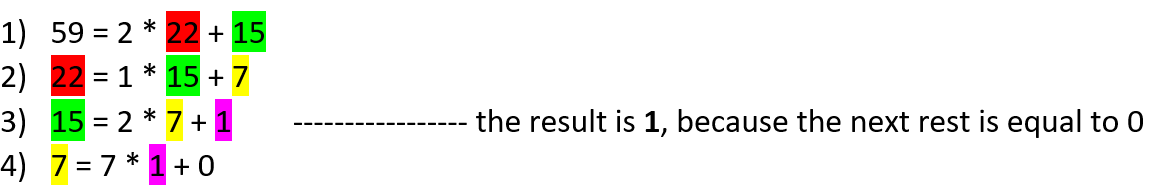

In [56]:
def GCD(a, b):
    if a < 1 or b < 1:
        raise ValueError()
    while b > 0:
        a, b = b, a % b
    return a

print(f"{GCD(22, 59)=}")
print(f"{GCD(7, 15)=}")
print(f"{GCD(49, 101)=}")
print(f"{GCD(66, 123)=}")

GCD(22, 59)=1
GCD(7, 15)=1
GCD(49, 101)=1
GCD(66, 123)=3


## Invers Modulo

Przypominijmy sobie, że inwersja modularna to inaczej rozwiązanie równania:

\begin{equation}
  x = a^{-1} \text{ mod } b
\end{equation}
Gdzie wartości $a$ oraz $b$ są nam znane. Zagadnienie to okazuje się wcale nie takie trywialne.


### Małe Twierdzenie Fermata

Jeżeli $b$ **jest liczbą pierwszą**, to sprawa się upraszcza, gdyż Fermat udowodnił, że w takiej sytuacji dla każdej wartości $a$, wartość $a^{b} - a$ jest wielokrtonością $b$. Czyli inaczej mówiąc:

\begin{equation}
  a^b = a \text{ mod } b
\end{equation}

A co za tym idzie:

\begin{align}
  a^b &= a \text{ mod } b \text{ |:a } \\
  a^{b - 1} &= 1 \text{ mod } b \text{ |:a } \\
  a^{b - 2} &= a^{-1} \text{ mod } b
\end{align}

In [57]:
def fermat_inverse(a, b):
    return pow(a, b-2, b)

## Rozszerzone Twierdzenie Euklidesa

Jeżeli $b$ nie jest liczbą pierwszą, sprawy się nieco komplikują. Wciąż musimy pamiętać, że aby istniała inwersja modularna musi być spełniony warunek: $GCD(a,b) = 1$. Poza tym, z pomocą nam przychodzi Rozszerzony Algorytm Euklidesa. Znowu, najłatwiej go zrozumieć na przykładzie, więc spójrz jak by wyglądało znalezienie wartości $22^{-1} \text{ mod } 59$: 

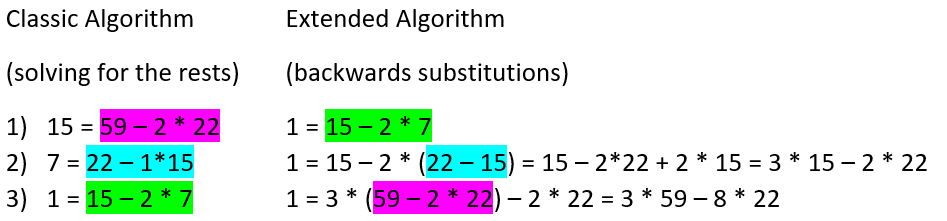

Jak nam to pomaga? Otóż wartość $GCD(a, b)$ można inaczej przedstawić jako: $GCD(a, b) = x * a + y * b$, gdzie $x$ oraz $y$ to liczby całkowite, a wartość $x \text{ mod } b$ to jest nasze szukane rozwiązanie inwersji. Czyli dla powyższego przykładu można zapisać, że $GCD(22, 59) = 1 = 3 * 59 – 8 * 22 = (-8) * 22 + 3 * 59$. Nasz $x = -8$, a więc $x \text{ mod } b = -8 \text{ mod } 59 = 51$, i to jest nasz wynik.

Ten algorytm w takiej formie oczywiście da się zaprogramować, ale wcale nie jest to aż tak trywialne. Problem polega na tym, że obliczamy w nim $x$ oraz $y$, a wartości $y$ wcale nie potrzebujemy. Stąd uproszczona wersja algorytmu, dedykowana do inwersji modularnej:

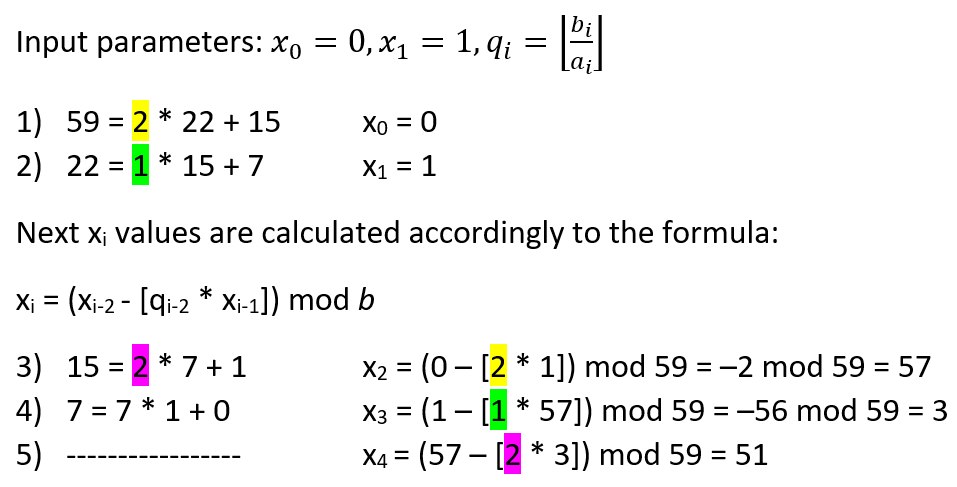

Ta wersja pozwala nam de facto wykonywać klasyczną wersję algorytmu Euklidesa obliczając jednocześnie to, co nas interesuje z wersji rozszerzonej.

In [58]:
def euclidean_inverse(a, b):
    if a < 1 or b < 1:
        raise ValueError()
    B = b
    
    q = []
    a = a % b
    while a > 0:
        a, b, qi = b % a, a, b // a
        q.append(qi)
    
    x0, x1 = 0, 1
    for qi in q[:-1]:
        x0, x1 = x1, (x0 - (qi * x1)) % B
    return x1

def inverse(a, b):
    if cu.isPrime(b):
        print("fermat_", end="")
        return fermat_inverse(a, b)
    print("euclidean_", end="")
    return euclidean_inverse(a, b)

print(f"{inverse(22, 59)=}")
print(f"{inverse(7, 15)=}")
print(f"{inverse(49, 101)=}")
print(f"{inverse(66, 123)=}")

fermat_inverse(22, 59)=51
euclidean_inverse(7, 15)=13
fermat_inverse(49, 101)=33
euclidean_inverse(66, 123)=110


## Podpisy Schnorra



Podpisy Schnorra wyparły ECDSA np. w bitcoinie. Są bezpieczne, efektywne i szybkie - za wyjątkiem tworzeniem ich bazy, tj. grupy Schnorra.

### Generowanie grupy Schnorra:

1. Wygeneruj 2 liczby pierwsze: $p$ oraz $q$, a następnie wygeneruj liczbę naturalną $r$ taką, że $p = qr + 1$.
2. Wyznacz losowe naturalne $h$ z przedziału $(1, p-1)$ spełniające warunek, że $h^r != 1 \text{ mod } p$.
3. Generatorem grupy Schnorra jest $g = h^r \text{ mod } p$. Rząd $g$ wynosi $q$. Właśnie to jest duża zaleta, mimo wszystko łatwiej wygenerować grupę Schnorra niż np. krzywą eliptyczną. 

Dodatkowe warunki:
1. $q$ ma $300$ bitów.
2. $r$ ma mieć $2400$ bitów.
3. $h$ ma mieć przynajmniej $128$ bitów.

Problematyczny jest punkt numer 1, mamy kilka liczb, która mają spełniać określone warunki. Tym razem posłużymy się brute forcem, czyli będziemy losowali do skutku. Podpowiedź: zaczniij od losowania $q$ oraz $r$, $p$ jedynie obliczaj. Wyliczenie wszystkich parametrów może chwilę trwać, ale powinno zabierać nie więcej niż 3 minuty (podaję z zapasem). Jak je raz wyliczysz, możesz zahardkować aby nie czekać za każdym razem.


In [59]:
# while True:
#     q = cu.getPrime(300)
#     r = cu.getRandomNBitInteger(2400)
#     p = q * r + 1
#     if cu.isPrime(p):
#         print(f"{p=}, {q=}, {r=}")
#         break

In [60]:
p = 299582976233680524560267222584664167051709859159519411497248875231221657980968044093863134043180696808952419744286634530459057199237057816943075685951683283917669337114934808039384229094497982804103308672109976179324389284028752117048245063416370871126785956014490460410737543175740832647197947587307771580373395529806288694421525177419009829102814917103935527633037422086607137116935872069352639384434289568633935654829354001224790571835466318504292247896082410175300687533366513792054222413166377985211871811213411208143886972277883111022374038372127775155025188535406793745121632422536699275726575223567165319789132921404500654819958201015198579119106538046251037498810267555019206354600655231615060410067325580983516533440190536982207415226542226990788637653625089956711736399525031712205069455352275916869621
q = 1273408039260881360740208685413932641922719094230989722202396217481206190443074215828638809
r = 235260786014486100300170189118798309968248722820475671573153175043873275168799881245155592607171727134867769730655899711655744651970585632103181796932915169935401965648431424609941267011658244806522813504853646919835113097102786931605622825397206327181161300660527504561045808276698046569878008108917319183503995175122638304703910716053375417926498011979234025837038722922474240434552336748917425428565033909184807540389921577940839636828525581351905292474850965340300034670685243216106853626825305659989279171263910528627995142832444420869840772865583051552311938387465645753252412021251145512103933866228129949250653900158404527928676188557374509260190101553202804960971139732772181876578780705369552846923951194503676180

In [61]:
def generate_schnorr_group():
    g = 1
    while g == 1:
        h = cu.getRandomRange(pow(2, 128), p)
        g = pow(h, r, p)
    return g

g = generate_schnorr_group()

### Podpis Schnorra

Wymaga uprzedniego utworzenia grupy Schnorra. Zapewnia nam dokładnie to, co każdy podpis cyfrowy. Niech $m$ oznacza bajty wiadomości, a $H$ funkcję skrótu SHA-256. Parametry grupy Schnorra które znamy to $g, p, q$.

**Generowanie kluczy:**
1. Wygeneruj losową liczbę naturalną $x$ z przedzdiału $(1, q - 1)$. Jest to klcuz prywatny.
2. Oblicz $y = g^x \text{ mod } p$. Jest to klcuz publiczny.

**Sygnatura wiadomości:**
1. Wygeneruj losową liczbę $r$ z przedziału $(1, q - 1)$.
2. Oblicz $g' = g^r \text{ mod } p$.
3. Oblicz $c = H(m||g')$.
4. Oblicz $s = (r - cx) \text{ mod } q$.
5. Zwróć parę $(s, c)$ jako podpis.

**Weryfikacja sygnatury:**
1. Oblicz $g' = (g^sy^c) \text{ mod } p$.
2. Oblicz $c' = H(m||g')$.
3. Jeżeli $c = c'$ weryfikacja przebiegła prawidłowo, w przeciwnym razie zwróć błąd weryfikacji.


Na nasze potrzeby niech $x$ oraz $r$ mają 128 bitów.



In [62]:
import hashlib as hl

n = 256

def H(input: int | str) -> int:
    if isinstance(input, int):
        size = cu.size(input) // 8 + 1
        mess = input.to_bytes(size)
    elif isinstance(input, bytes):
        mess = input
    else:
        mess = input.encode("utf-8")
    hash = hl.sha256(mess).digest()
    return int.from_bytes(hash)

In [63]:
def generate_keys_shnorr():
    x = cu.getRandomRange(pow(2, 128), q)
    y = pow(g, x, p)
    return x, y

def concat(mess, num):
    size = cu.size(num) // 8 + 1
    return mess.encode("utf-8") + num.to_bytes(size)

def sig_shnorr(m, key):
    r = cu.getRandomRange(pow(2, 128), q)
    g_prim = pow(g, r, p)
    c = H(concat(m, g_prim))
    s = (r - c * key) % q
    return s, c

def verify_shnorr(m, s, c, key):
    g_prim = (pow(g, s, p) * pow(key, c, p)) % p
    c_prim = H(concat(m, g_prim))
    return c == c_prim

In [64]:
message = "Ala ma podpis"

sk, pk  = generate_keys_shnorr()

SIG, c = sig_shnorr(message, sk)
print(f"SIG = {SIG}")

verify_shnorr(message, SIG, c, pk)

SIG = 774186027255595158201566083093135509212117978621553555211792739513738525510088162497812126


True

In [65]:
message = "Ala ma podpis"

sk, pk  = generate_keys_shnorr()

SIG, c = sig_shnorr(message, sk)
print(f"SIG = {SIG}")

verify_shnorr("Ala nie ma podpisu", SIG, c, pk)

SIG = 448123104969451772566576964117295195406422590321649466258107832512752556727358615498912692


False

In [66]:
message = "Ala ma podpis"

sk, pk  = generate_keys_shnorr()

SIG, c = sig_shnorr(message, sk)
print(f"SIG = {SIG}")

verify_shnorr(message, SIG, c + 1, pk)

SIG = 1227440004481365302320726130730404825985088297308373081376777947416060979559166094408048655


False

## Ślepy podpis Schnorra

Czasami jest tak, że podpisujący ma nie wiedzieć co podpisuje. To znaczy, że twórca wiadomości i podpisujący to dwie różne instancje. Wówczas przydaje się tzw. algorytm ślepego podpisu. Zobaczmy jak wygląda. Wszystkie strony komunikacji znają $g, p, q$. Klucze $x$ oraz $y$ generowane są **tak samo jak w algorytmie podpisu Schnorra**.

**Faza 1 (podpisujący):**
1. Wygeneruj losową liczbę naturalną $r$ z przedziału $(1, q - 1 )$.
2. Oblicz $t' = g^r \text{ mod } p$.
3. Przekaż $t'$ **autorowi wiadomości**.

**Faza 2 (autor wiadomości):**
1. Wygeneruj losową liczbę $\gamma$ z przedziału $(1, q - 1)$.
2. Wygeneruj losową liczbę $\delta$ z przedziału $(1, q - 1)$.
3. Oblicz $t = (g^{\gamma}y^{\delta}t') \text{ mod } p$.
4. Oblicz $c = H(m||t)$.
5. Oblicz $c' = (c - \delta) \text{ mod } q$.
6. Przekaż $c'$ **podpisującemu**.

**Faza 3 (podpisujący):**
1. Oblicz $s' = (r - c'x) \text{ mod } q$.
2. Przekaż $s'$ **autorowi wiadomości**.

**Faza 4 (autor):**
1. Oblicz $s = (s' + \gamma) \text{ mod } q$. Podpis stanowi para $(s, c)$, która jest wysyłana weryfikującemu.

**Faza 5 (weryfikujący):**
1. Oblicz $g' = (g^sy^c) \text{ mod } p$.
2. Oblicz $c' = H(m||g')$.
3. Jeżeli $c = c'$, weryfikacja przebiegła pomyślnie. W przeciwnym razie zwróć błąd weryfikacji.


Na nasze potrzeby niech $x$, $r$, $\gamma$ oraz $\delta$ mają 128 bitów. Uważaj, gdzie liczymy modulo $p$, a gdzie modulo $q$.

In [73]:
x, y = generate_keys_shnorr()

In [74]:
# Faza 1
r = cu.getRandomRange(pow(2, 128), q)
t_prim = pow(g, r, p)

# return t_prim

In [75]:
# Faza 2
message = "Ala ma podpis"

gamma = cu.getRandomRange(pow(2, 128), q)
delta = cu.getRandomRange(pow(2, 128), q)
t = (pow(g, gamma, p) * pow(y, delta, p) * t_prim) % p
c = H(concat(message, t))
c_prim = (c - delta) % q

# return c_prim


In [76]:
# Faza 3
s_prim = (r - c_prim * x) % q

# return s_prim

In [77]:
# Faza 4
s = (s_prim + gamma) % q

# return s, c

In [78]:
# Faza 5
g_prim = (pow(g, s, p) * pow(y, c, p)) % p
c_prim = H(concat(message, g_prim))

assert c == c_prim
print("Verified")

Verified


## Zadania

1. Napisz szyfrowanie oraz deszyfrowanie Vernama. Klucz generuj z wykorzystaniem PRNG Blum-Blum-Shub. Niech $n$ ma 2048 bitów oraz niech $p$ i $q$ różnią się o przynajmniej 128 bitów, ale nie więcej niż 256. Tę różnicę losuj, a nie hardkoduj.

2. Zaimplementuj algorytm Euklidesa i oblicz:  GCD(22, 59), GCD(7, 15), GCD(49, 101) and GCD(66, 123).

3. Zaimplementuj rozszerzony Algorytm Euklidesa (w uproszczonej wersji) oraz Małe Twierdzenie Fermata, a następnie z wykorzystaniem obu (tam gdzie się da) oblicz: $22^{-1} \text{ mod } 59$, $7^{-1} \text{ mod } 15$, $49^{-1} \text{ mod } 101$, $66^{-1} \text{ mod } 123$. 

4. Zaimplementuj generowanie grupy Schnorra, podpis Schnorra oraz ślepy podpis Schnorra. Zaprezentuj działanie algorytmów dla dowolnej wiadomości.